矩形抽出でカットした画像に対して、改めてグレースケールとバイナリーを入れる

画像 (ケース番号: 3)


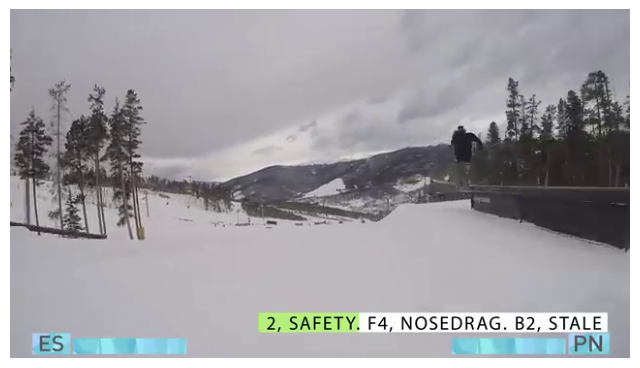

In [1]:
from slvsh_tr.example import load_examples
import cv2
import matplotlib.pyplot as plt

examples = load_examples()
example = examples[2]
image = example.get_image()
case_number = example.get_case_number()

# BGRからRGBに変換 (OpenCVはデフォルトでBGRを使用)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 画像とcase_numberを表示
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis('off')
print(f'画像 (ケース番号: {case_number})')
plt.show()

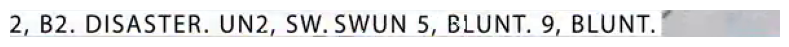

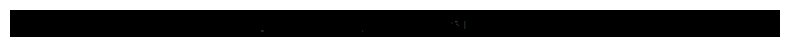

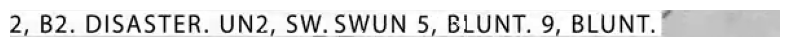

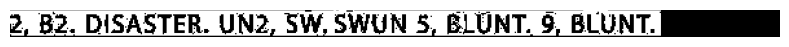

テキスト領域: (0, 0, 503, 20)


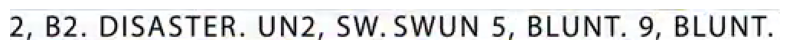

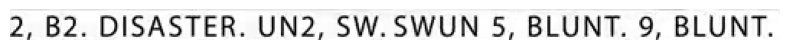

'2, B2. DISASTER. UN2. SW.SWUN 5, BLUNT. 9, BLUNT.'

In [4]:
from slvsh_tr import Recognizer
import cv2
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectWhitning4Recognizer(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def whiten_red_and_green(self, image: cv2.typing.MatLike) -> cv2.typing.MatLike:
        # BGRからHSV色空間に変換
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # 緑色の範囲を定義（HSV色空間）
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 赤色の範囲を定義（HSV色空間）- 明るい赤のみ
        lower_red2 = np.array([170, 100, 100])
        upper_red2 = np.array([180, 255, 255])
        
        # マスクの作成
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask_green, mask_red2)
        # 結果画像の作成
        result = image.copy()
        result[mask > 0] = [255, 255, 255]
        
        if self.debug:
            display_image(result)
            # マスクされた領域を可視化
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            display_image(masked_image)
        
        return result

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY) #真っ白の四角を対象にする
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.05 and h > height * 0.9:
                # 右端または左端にアラインされているか確認
                if x < width * 0.05 or x + w > width * 0.95:
                    text_regions.append((x, y, w, h))
        
        if text_regions:
            # 幅が最大のものを選択
            return max(text_regions, key=lambda r: r[2])
        
        return None
    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), int(width * 0.035):int(width * 0.965)]
        
        original_roi = roi.copy()
        roi = self.whiten_red_and_green(roi)
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. /"'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            return ""
        else:
            x, y, w, h = text_region
            target_image = original_roi[y:y+h, x:x+w]
            
            # グレースケール化
            gray_target = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)

        extracted_text = pytesseract.image_to_string(gray_target, config=config).strip()

        if self.debug:
            display_image(target_image)
            display_image(gray_target)

        return extracted_text

model = TesseractFindRectWhitning4Recognizer(debug=True)
model.infer(examples[31].get_image())

In [5]:
from slvsh_tr import eval
import pandas as pd

model = TesseractFindRectWhitning4Recognizer()
result = eval(model)

# 評価結果をDataFrameに変換
df = pd.DataFrame([r.dump() for r in result])
df.mean(numeric_only=True)

例の評価中: 100%|██████████| 178/178 [00:52<00:00,  3.39it/s]


case_number    89.500000
precision       0.958176
recall          0.951693
f1              0.942797
dtype: float64

グレースケール入れてもあんまり変わらず。precisionはちょっと良くなって、recallはちょっと下がった  
バイナリ化を入れるとジャギってカンマとコロンの認識精度が落ちる
